In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Lambda, LSTM, RepeatVector
from keras.models import Model
from keras import backend as K
from keras import metrics
from scipy.stats import norm
import pandas as pd
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Read Data Set

In [3]:
df = pd.read_csv("data/EEG_Eye_State.arff",comment="@",header = None)

+ Extract the label

In [4]:
y = df[df.columns[-1]]
del df[df.columns[-1]]

+ filter outliers

In [5]:
highest_quantile = np.percentile(df,99,axis=0)
df[df > highest_quantile] = np.nan
df = df.fillna(df.quantile(0.99))

In [6]:
lowest_quantile = np.percentile(df,1,axis=0)
df[df < lowest_quantile] = np.nan
df = df.fillna(df.quantile(0.01))

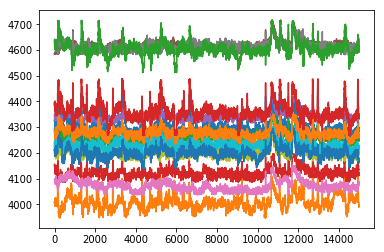

In [7]:
_ = plt.plot(df)

+ Normalize data

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

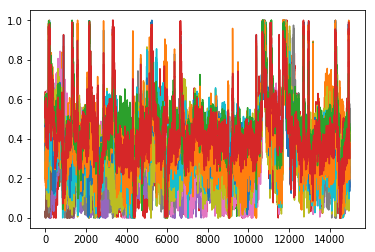

In [9]:
_ = plt.plot(df)

+ Differentiate

In [10]:
def difference(dataset, interval=1):
    return dataset[interval:,:] - dataset[:-interval,:]

In [11]:
#df = difference(df)

+ Make small time series

In [12]:
jump = 1
timesteps = 5
indexes = [range(i,i+timesteps) for i in range(0,df.shape[0]-jump-timesteps,jump)]
X = df[indexes]

+ Split dataset into train and test set

In [13]:
train_size_proportion = 0.67
train_size = int(len(X) * train_size_proportion)
test_size = len(X) - train_size
train, test = X[0:train_size,:], X[train_size:len(X),:]

# Vanilla LSTM Auto-Encoder

In [14]:
from keras.models import Sequential,Model
from keras.layers import LSTM,Dense,RepeatVector,TimeDistributed,Input

In [15]:
nb_dims = train.shape[-1]
hidden_dim = 20
batch_size = 5
input_layer = Input(batch_shape=(None, timesteps, nb_dims))
encoder_layer = LSTM(hidden_dim,
                     stateful=False)

repeat_layer = RepeatVector(timesteps)
input_decoder_layer = Input(batch_shape=(None, timesteps,hidden_dim))
decoder_lstm_layer = LSTM(hidden_dim,
                          return_sequences=True,
                          stateful=False)
decoder_dense_layer = TimeDistributed(Dense(nb_dims, activation='tanh'))

### Encoder

In [16]:
encoder = encoder_layer(input_layer)
encoder_model = Model(input_layer, encoder)
encoder_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

### Decoder

In [17]:
decoder_lstm = decoder_lstm_layer(input_decoder_layer)
decoder = decoder_dense_layer(decoder_lstm)
decoder_model = Model(input_decoder_layer,decoder)
decoder_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

### Auto-Encoder

In [18]:
repeater = repeat_layer(encoder)
lstm_decoder = decoder_lstm_layer(repeater)
autoencoder = decoder_dense_layer(lstm_decoder)
autoencoder_model = Model(input_layer,autoencoder)
autoencoder_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

# Fit 

In [19]:
nb_epoch = 20
validation_split = 0.1
filepath_loss = "checkpoint/better_loss_.hdf5"
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='loss',
                                  verbose=0,
                                  save_best_only=True,
                                  mode='auto')
filepath_val_loss = "checkpoint/better_val_loss_epoch-{epoch:02d}.hdf5"   
checkpoint_val_loss = ModelCheckpoint(filepath_val_loss,
                                      monitor='val_loss',
                                      verbose=0,
                                      save_best_only=True,
                                      mode='auto')
callbacks_list = [checkpoint_loss,
                  checkpoint_val_loss]
history =autoencoder_model.fit(train,
                               train,
                               batch_size,
                               nb_epoch,
                               callbacks = callbacks_list,
                               validation_split=validation_split,
                               verbose = 1,
                               shuffle = True)

Train on 9028 samples, validate on 1004 samples
Epoch 1/20
9028/9028 [==============================] - 40s - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0597 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0427
Epoch 2/20
9028/9028 [==============================] - 44s - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0372 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0367
Epoch 3/20
9028/9028 [==============================] - 42s - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0330 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0326
Epoch 4/20
9028/9028 [==============================] - 42s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0300 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0301
Epoch 5/20
9028/9028 [==============================] - 42s - loss: 0.00

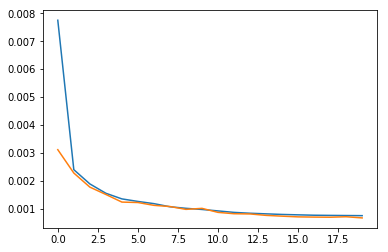

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Predict

In [21]:
x_test_encoded = encoder_model.predict(X, batch_size=batch_size)

In [22]:
x_test_encoded.shape

(14974, 20)

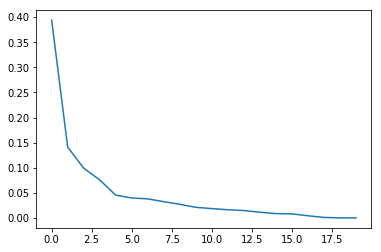

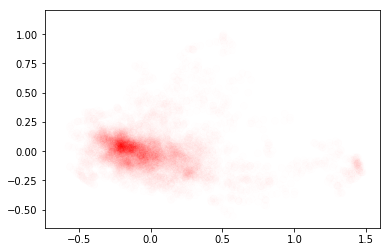

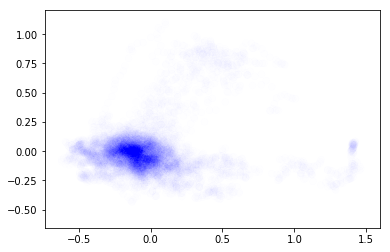

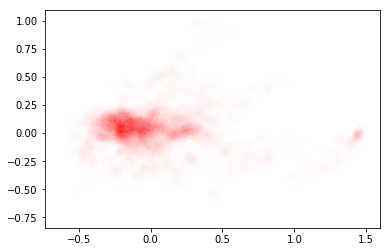

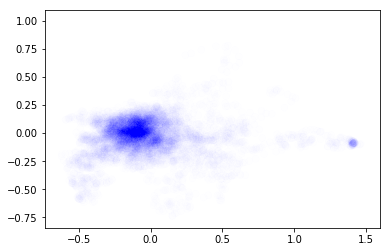

In [23]:
from sklearn import decomposition
pca = decomposition.PCA(x_test_encoded.shape[1])
pca.fit(x_test_encoded)
x_test_pca = pd.DataFrame(pca.transform(x_test_encoded))
#plt.plot(X_pc)
plt.plot(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)
plt.figure()
colors_map = {1:"red", 0:"None"}
plt.scatter(x_test_pca[0], x_test_pca[1], c=map(colors_map.__getitem__,y), alpha = 0.003,s=50)
plt.figure()
colors_map = {1:"None", 0:"Blue"}
plt.scatter(x_test_pca[0], x_test_pca[1], c=map(colors_map.__getitem__,y), alpha = 0.003,s=50)

plt.figure()
colors_map = {1:"red", 0:"None"}
plt.scatter(x_test_pca[0], x_test_pca[2], c=map(colors_map.__getitem__,y), alpha = 0.003,s=50)
plt.figure()
colors_map = {1:"None", 0:"Blue"}
plt.scatter(x_test_pca[0], x_test_pca[2], c=map(colors_map.__getitem__,y), alpha = 0.003,s=50)


# Generate

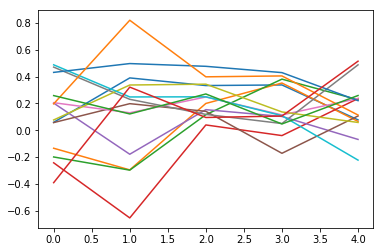

In [24]:
a = decoder_model.predict(np.random.randn(1,timesteps,hidden_dim))
_ = plt.plot(a.reshape(5,14))


# Towards anomaly detection

### Predict train set

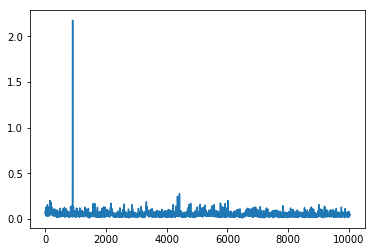

In [29]:
X_train_pred = autoencoder_model.predict(train)
results = ((X_train_pred - train)**2).sum(2).sum(1)
plt.plot(results)

### Choose a threshold

In [37]:
th = np.percentile(results,99.9)

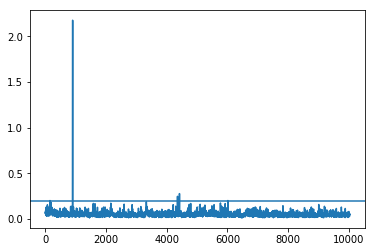

In [38]:
plt.plot(results)
plt.axhline(y=th, xmin=0, xmax=results.shape[0], hold=None)


### Predict Test set

In [39]:
X_test_pred = autoencoder_model.predict(test)

In [40]:
results = ((X_test_pred - test)**2).sum(2).sum(1)

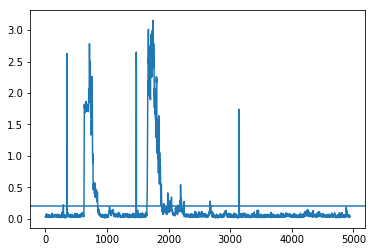

In [41]:
plt.plot(results)
plt.axhline(y=th, xmin=0, xmax=results.shape[0], hold=None)

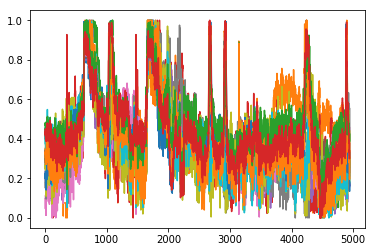

In [42]:
_ = plt.plot(df[int(df.shape[0]*0.67):,:])

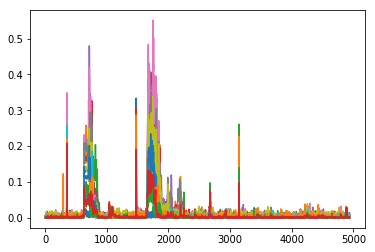

In [43]:
results = ((X_test_pred - test)**2).sum(1)
plt.plot(results)

# References

https://machinelearningmastery.com/models-sequence-prediction-recurrent-neural-networks/
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
https://github.com/fchollet/keras/blob/master/examples/lstm_seq2seq.py
https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/
https://machinelearningmastery.com/how-to-use-an-encoder-decoder-lstm-to-echo-sequences-of-random-integers/
https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/
https://machinelearningmastery.com/learn-add-numbers-seq2seq-recurrent-neural-networks/
    